In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
def import_PV_WT_data():
    """
    Returns
    -------
    PV : dict
        Holds data regarding the PV string in SYSLAB 715
    WT : dict
        Holds data regarding the Gaia wind turbine
    """

    PV={
        "Type": "Poly-cristaline",
        "Az": 60,#deg
        "Estc": 1000, #W/m**2
        "Tstc": 25,#C
        'Pmp_stc' : [165, 125], #W
        'ganma_mp' : [-0.478/100, -0.45/100], #1/K
        'Ns':[18, 6], #int
        'Np':[2, 2], #int
        'a' : [-3.56, -3.56], #module material construction parameters a, b and D_T
        'b' : [-0.0750, -0.0750],
        'D_T' : [3, 3],# represents the difference between the module and cell temperature
                        #these three parameters correspond to glass/cell/polymer sheet with open rack
                        #they are extracted from Sandia document King, Boyson form 2004 page 20
        'eff_P' : [[0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000],
                   [0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000]],
        'eff_%' : [[0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98],
                   [0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98]],
       "index": ['A','B'], #A and B refer to each channel of the inverter, which has connected a different string.
        }

    WT={
        "Type": "Asynchronous",
        "Mode": "Passive, downwind vaning",
        "Pn": 11,#kW
        "Vn": 400,#V
        'CWs' : [3.5, 6, 8, 10, 10.5, 11, 12, 13, 13.4, 14, 16, 18, 20, 22, 24, 25,],#m/s
        'CP' : [0, 5, 8.5, 10.9, 11.2, 11.3, 11.2, 10.5, 10.5, 10, 8.8, 8.7, 8, 7.3, 6.6, 6.3,],#kW
        "Cin": 3.5,#m/s
        "Cout": 25,#m/s
        "HH": 18,#m
        "D": 13,#m
        "SA": 137.7,#m**2
        "B": 2,#int
        }

    return PV, WT


def ExpandSOLETE(data, info, Control_Var):
    """

    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    info : list
        Contains PVinfo and WTinfo which are dicts
    Control_Var : dict
        Holds information regarding what to do

    Returns
    -------
    Adds columns to data with new metrics. Some from the PV performance model [1], others from potentially useful metrics.
    """
    ncol=len(data.columns)

    print("Expanding SOLETE with King's PV Performance Model")
    data['Pac'], data['Pdc'], data['TempModule'], data['TempCell'] = PV_Performance_Model(data, info[0])
    print("Cleaning noise and curtailment from active power production")
    data['P_Solar[kW]'] =  np.where(data['Pac'] >= 1.5*data['P_Solar[kW]'],
                                    data['Pac'], data['P_Solar[kW]'])
    print("Smoothing zeros")
    data['P_Solar[kW]'] =  np.where(data['P_Solar[kW]'] <= 0.001,
                                      0, data['P_Solar[kW]'])
    data['Pac'] =  np.where(data['Pac'] <= 0.001,
                                      0, data['Pac'])

    print("\nAdding new Types with codes: " + str(Control_Var['PossibleFeatures']))


    if 'HoursOfDay' in Control_Var['PossibleFeatures']: #time of the day hours
        data['HoursOfDay'] =  data.index.hour
    if 'MeanPrevH' in Control_Var['PossibleFeatures']: #mean previous horizon
        data['MeanPrevH'] =  data[ Control_Var['IntrinsicFeature']].rolling(Control_Var['H']).mean()
    if 'StdPrevH' in Control_Var['PossibleFeatures']: #std previous horizon
        data['StdPrevH'] =  data[Control_Var['IntrinsicFeature']].rolling(Control_Var['H']).std()
    if 'MeanWindSpeedPrevH' in Control_Var['PossibleFeatures']: #wind speed mean of the previous horizon
        data['MeanWindSpeedPrevH'] =  data['WIND_SPEED[m1s]'].rolling(Control_Var['H']).mean()
    if 'StdWindSpeedPrevH' in Control_Var['PossibleFeatures']: #wind speed std of the previous horizon
        data['StdWindSpeedPrevH'] =  data['WIND_SPEED[m1s]'].rolling(Control_Var['H']).std()


    print("\nSOLETE has been successfully expanded from:", ncol, "to:", len(data.columns), "features.\n\n")


    pass


def PV_Performance_Model(data, PVinfo, colirra='POA Irr[kW1m2]'):
    """
    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    PVinfo : dict
        A bunch of parameters extracted from the datasheet and other supporting documents
        Check function: import_PV_WT_data for further details
    colirra : string
        holds Epoa, that is the irradiance in the plane of the array.
        If you reuse this code, make sure you are feeding Epoa and not GHI
        The default is 'POA Irr[kW1m2]'.
    Returns
    -------
    DataFrames
        Pac, Pdc, Tm, and Tc. [1]
    """


    # Obtains the expected solar production based on irradiance, temperature, pv parameters, etc
    DATA_PV = pd.DataFrame({'Pmp_stc' : PVinfo["Pmp_stc"],
                            'ganma_mp' : PVinfo['ganma_mp'],
                            'Ns': PVinfo['Ns'],
                            'Np': PVinfo['Np'],
                            'a' : PVinfo['a'],
                            'b' : PVinfo['b'],
                            'D_T' : PVinfo['D_T'],
                            'eff_P' : PVinfo['eff_P'],
                            'eff_%' : PVinfo['eff_%'],
                            },
                           index = PVinfo["index"])

    DATA_PV['eff_max_%'] = [max(DATA_PV['eff_%'].loc['A']), max(DATA_PV['eff_%'].loc['B'])] #maximum inverter efficiency in %
    DATA_PV['eff_max_P'] = [max(DATA_PV['eff_P'].loc['A']), max(DATA_PV['eff_P'].loc['B'])] #W maximum power output of the inverter

    Results = pd.DataFrame(index = data.index)

    for pv in DATA_PV.index:
        #Temperature Module
        Results['Tm_' + pv] = data['TEMPERATURE[degC]'] + data[colirra]*1000 *np.exp(DATA_PV.loc[pv,'a']+DATA_PV.loc[pv,'b']*data['WIND_SPEED[m1s]'])
        #Temperature Cell
        Results['Tc_' + pv] = Results['Tm_' + pv] + data[colirra]*1000/PVinfo["Estc"] * DATA_PV.loc[pv,'D_T']
        #power produced in one single pannel
        Results['Pmp_panel_' + pv] = data[colirra]*1000/PVinfo["Estc"] * DATA_PV.loc[pv, 'Pmp_stc'] * (1+DATA_PV.loc[pv, 'ganma_mp'] * (Results['Tc_' + pv] - PVinfo["Tstc"]) )
        #power produced by all the panels in the array
        Results['Pmp_array_' + pv] = DATA_PV.loc[pv, 'Ns'] * DATA_PV.loc[pv, 'Np'] * Results['Pmp_panel_' + pv]
        #efficiency of the inverter corresponding to the instantaneous power output
        Results['eff_inv_' + pv] =  np.interp(Results['Pmp_array_' + pv], DATA_PV.loc[pv, 'eff_P'], DATA_PV.loc[pv, 'eff_%'], left=0)/100


        Results['Pac_' + pv] =  DATA_PV.loc[pv, 'eff_max_%']/100 * Results['Pmp_array_' + pv]
        Results[Results['Pac_' + pv]>DATA_PV.loc[pv, 'eff_max_P']]=DATA_PV.loc[pv, 'eff_max_P'] #If any of the Pac is > than the maximum capacity of the inverter
        # then use the max capacity of the inverter
        Results[Results['Pac_' + pv]<0]=0

    return Results[['Pac_A', 'Pac_B']].sum(axis=1)/1000, Results[['Pmp_array_A', 'Pmp_array_B']].sum(axis=1)/1000, Results[['Tm_A', 'Tm_B']].mean(axis=1), Results[['Tc_A', 'Tc_B']].mean(axis=1)

def TimePeriods(data, control):
    """
    A function that will split the time series to input and output for training
    of the forecast problem with supervised learning
    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    control : dict
        Control_Var.
    Returns
    -------
    dik : dict of DataFrames
        cotains the train and testing sets for RF and SVM
        or the train, validation and testing for ANN

    Arguments
    ---------
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        base: Is the basic variable that will be shifted back and forward in time, e.g. Pestimated
        additions: are the other variables that will tag along base to complete the dataset
        train_val_test = division of timestamps in the three blocks
    """
    n_in=control["PRE"]
    n_out=control["H"]
    base=control["IntrinsicFeature"]
    additions= control["PossibleFeatures"].copy()
    #additions.remove(control["IntrinsicFeature"])
    train_val_test = control['Train_Val_Test']

    if control['MLtype'] in ['RF', 'SVM']:
        data.fillna(0, inplace=True)

        BASE = series_to_supervised(data[base], n_in, n_out, dropnan=False)

        col_loc_base = []
        for addition in additions:
            BASE[addition] = data[addition]
            col_loc_base.append(BASE.columns.get_loc(addition))


        BASE.dropna(inplace=True)


        X_COLS = [*range(0,n_in+1)]+col_loc_base  #because they are the PRE+t0 current sample
        Y_COLS = [*range(n_in+1,n_in+n_out+1)]

        X=BASE.iloc[:, X_COLS]
        Y=BASE.iloc[:, Y_COLS]
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=train_val_test[-1]/100, shuffle=False, random_state=None)

        Scaler = {
                  'X_data' : 1,
                  'Y_data' : 1,
                  }


        ML_DATA = {
            "X_TRAIN": X_TRAIN.sort_index(),
            "X_TEST": X_TEST.sort_index(),
            "Y_TRAIN": Y_TRAIN.sort_index(),
            "Y_TEST": Y_TEST.sort_index(),
            "Y_TEST_abs": Y_TEST.sort_index(),
            }


    elif control['MLtype'] in ['LSTM', 'CNN', 'CNN_LSTM']:
        Xscaler = MinMaxScaler(feature_range=(0, 1)) #initialise the scaler
        Yscaler = MinMaxScaler(feature_range=(0, 1)) #initialise the scaler

        X = data[additions]
        Y = data[base]

        X = series_to_forecast(X, n_in, 0, dropnan=False)#.drop(X.index[-(n_out):])
        Y = series_to_forecast(Y, 0, n_out, dropnan=False).drop(base+'_(t)', axis=1)#.drop(Y.index[:(n_in)])

        X_TRAIN, X_VAL_TEST, Y_TRAIN, Y_VAL_TEST = train_test_split(X, Y, train_size=train_val_test[0]/100, shuffle=False, random_state=None)

        del X, Y

        X_VAL, X_TEST, Y_VAL, Y_TEST = train_test_split(X_VAL_TEST, Y_VAL_TEST, train_size=train_val_test[1]/(100-train_val_test[0]), shuffle=False, random_state=None)

        del X_VAL_TEST, Y_VAL_TEST

        #apply scaler to keep all values between 0 and 1
        X_TRAIN = pd.DataFrame(Xscaler.fit_transform(X_TRAIN), index=X_TRAIN.index, columns = X_TRAIN.columns)
        X_VAL = pd.DataFrame(Xscaler.transform(X_VAL), index=X_VAL.index, columns = X_VAL.columns)
        X_TEST = pd.DataFrame(Xscaler.transform(X_TEST), index=X_TEST.index, columns = X_TEST.columns)

        Y_TRAIN = pd.DataFrame(Yscaler.fit_transform(Y_TRAIN), index=Y_TRAIN.index, columns = Y_TRAIN.columns)
        Y_VAL = pd.DataFrame(Yscaler.transform(Y_VAL), index=Y_VAL.index, columns = Y_VAL.columns)
        Y_TEST_abs = pd.DataFrame(Y_TEST, index=Y_TEST.index, columns = Y_TEST.columns)
        Y_TEST = pd.DataFrame(Yscaler.transform(Y_TEST), index=Y_TEST.index, columns = Y_TEST.columns)


        # apply masking as to substitute a complete row by 999 if any of its values is NAN (aka missing value)
        X_TRAIN.mask(X_TRAIN.isna().any(axis=1), other=999, inplace=True)
        X_VAL.mask(X_VAL.isna().any(axis=1), other=999, inplace=True)
        X_TEST.mask(X_TEST.isna().any(axis=1), other=999, inplace=True)

        Y_TRAIN.mask(Y_TRAIN.isna().any(axis=1), other=999, inplace=True)
        Y_VAL.mask(Y_VAL.isna().any(axis=1), other=999, inplace=True)
        Y_TEST.mask(Y_TEST.isna().any(axis=1), other=999, inplace=True)
        Y_TEST_abs.mask(Y_TEST_abs.isna().any(axis=1), other=999, inplace=True)


        Scaler = {
                  'X_data' : Xscaler,
                  'Y_data' : Yscaler,
                  }

        ML_DATA = {
            "X_TRAIN": X_TRAIN.sort_index(),
            "X_VAL": X_VAL.sort_index(),
            "X_TEST": X_TEST.sort_index().drop(X_TEST.tail(n_out).index, axis=0),
            "Y_TRAIN": Y_TRAIN.sort_index(),
            "Y_VAL": Y_VAL.sort_index(),
            "Y_TEST": Y_TEST.sort_index().drop(Y_TEST.tail(n_out).index, axis=0),
            "Y_TEST_abs": Y_TEST_abs.sort_index().drop(Y_TEST.tail(n_out).index, axis=0),
            }

    else:
        print("\n\n\n WARNING: Your ML method is not supported by the 'TimePeriods' function.\n\n")

    return ML_DATA, Scaler


def series_to_forecast(data, n_in, n_out, dropnan=True):
    """
    A function that will split the time series to input and output for training
    of the forecast problem with supervised learning
    Arguments:
        data: Sequence of observations as a list, NumPy array or pandas series
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """

    # n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    COLUMNS = df.columns
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(col_name + '_(t-%d)' % (i)) for col_name in COLUMNS]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out+1):
        cols.append(df.shift(-i))

        if i == 0:
            names += [(col_name + '_(t)') for col_name in COLUMNS]
        else:
            names += [(col_name + '_(t+%d)' % (i)) for col_name in COLUMNS]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [3]:
import matplotlib.pyplot as plt

In [4]:
"""
Created on Wed Nov 17 14:35:08 2021
@author: Daniel Vázquez Pombo
email: dvapo@elektro.dtu.dk
LinkedIn: https://www.linkedin.com/in/dvp/
ResearchGate: https://www.researchgate.net/profile/Daniel-Vazquez-Pombo
The purpose of this script is to give you a running example of the methodology presented in:
    [1] D.V. Pombo, H.W. Bindner, S.V. Spataru, P. Sørensen, P. Bacher,
    Increasing the Accuracy of Hourly Multi-Output Solar Power Forecast with
    Physics-Informed Machine Learning, Solar Energy. In Press.

It should run without errors simply by placing all the files in the same location.
We have checked the hdf5 file (the actual dataset) compatibility with both Python and R.
The lincensing of this work is pretty chill, just give credit: https://creativecommons.org/licenses/by/4.0/
How to use the first time:
    1- Put all the files in the same folder and click run. If you get the message "Done!" in the console that is it.
    2- If it didn't work:
        a) Check the dependencies:
            Python 3.8.10
            Pandas 1.2.4
            Numpy 1.19.5
            Matplotlib 3.4.2
            Scikit-Learn 0.24.2
            Keras 2.5.0
            TensorFlow 2.5.0
        b) If that didn't solve it... You have a problem my friend ¯\_(ツ)_/¯

How to use the second and subsequent times:
    1- Go to section: "Control the Script"
        In the dictionary called Control_Var you can modify different values, like the horizon to forecast,
        the division between training, validation and testing, what is the metric to be predicted, which
        should be used as extrinsic features, etc.
    2- Go to section: Define Machine Learning Configuration and Hyperparameters
        You can use those dictionaries to define different topologies for the 5 ML methods covered in [1]
        However, be careful with ANN, they have a particular shape, you cant control each layer's position
        from there. But you can edit that yourself.
    3- After setting those parameters just run it. Take into account the size of the data, it might take a while.
    4- If you found this useful, and want to send some kudos, do so.
DISCLAIMERS:
1- I was using a regular PC only for coding, models were run in an HPC.
2- There are better ways to configure the ML-models, have fun playing with it.
3- SVM will take for ever if run in this way for the whole set. An alternative formulation is -> https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python
4- I put together the dataset and this scripts in one day, so do not expect them to be pretty or 100% error free.
"""

import pandas as pd
#from Functions import import_PV_WT_data, ExpandSOLETE, TimePeriods, PrepareMLmodel, TestMLmodel, get_results, post_process



#%% Control The Script:

Control_Var = {
    '_description_' : 'Holds all the variables that define the behaviour of the algoritm',
    'trainVSimport' : True, #True - trains the ML model, False - imports the model
    'saveMLmodel' : True, #saves the trained model if True, but also trainVSimport must be True, otherwise does nothing.
    'Train_Val_Test' : [70, 20, 10], #train validation test division of the available DATA
    'IntrinsicFeature' : 'P_Solar[kW]', #feature to be predicted
    'PossibleFeatures': ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]',
                        'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'Pressure[mbar]',
                        'Pac', 'Pdc','TempModule', 'TempCell', 'HoursOfDay', 'MeanPrevH',
                        'StdPrevH', 'MeanWindSpeedPrevH', 'StdWindSpeedPrevH',
                        ],
    #'IntrinsicFeature' : 'Power',
    #'PossibleFeatures': ['Time','WindSpeed','Power'
                        #],
    'MLtype' : 'CNN_LSTM', #RF SVM LSTM CNN CNN_LSTM
    'H' : 24, #horizon length in number of samples
    # 'Features_IDs' : pd.DataFrame(Control_Var['PossibleFeatures'], columns = ['Features']),
    'PRE' : 30, #previous samples to be used in the predictor
    }

#%% Define Machine Learning Configuration and Hyperparameters
# edit this dictionaries to tailor-made the ML model that you want

RF = {'_description_' : 'Holds the values related to Random Forest',
        'n_trees' : 1, #number of trees
        'random_state' : 32, #initialization number, can be removed for random seed generation
        }

SVM = {'_description_' : 'Holds the values related to Support Vector Machine',
       'kernel' : 'rbf', #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ <--> default=’rbf’
        'degree' : 3, # Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
        'gamma' : 'scale', # ‘scale’, ‘auto’ -> if you don't know what you are doing leave it as scale
        'coef0' : 0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
        'C' : 3, # Regularization parameter. The strength of the regularization is inversely proportional to C.
                # Must be strictly positive. The penalty is a squared l2 penalty.
        'epsilon' : 0.1, # Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty
                        # is associated in the training loss function with points predicted within a distance epsilon from the actual value.
        }

LSTM = {'_description_' : 'Holds the values related to LSTM ANN design',
        'n_batch' : 16, #int <-> # number of samples fed together - helps with paralelization  (smaller takes longer, improves performance carefull with overfitting)
        'epo_num' : 1000, # 5 - epoc number of iterations of each batch - same reasoning as for the batches'
        'Neurons' : [15,15,15], #number of neurons per layer <-> you can feed up to three layers using list e.g. [15, 10] makes two layers of 15 and 10 neurons, respectively.
        'Dense'  : [0, 0], #number of dense layers and neurons in them. If left as 0 they are not created.
        'ActFun' : 'tanh', #sigmoid, tanh, elu, relu - activation function as a str
        'LossFun' : 'mean_absolute_error', #mean_absolute_error or mean_squared_error
        'Optimizer' : 'adam' # adam RMSProp - optimization method adam is the default of the guild
        }

CNN = {'_description_' : 'Holds the values related to LSTM NN design',
        'n_batch' : 16, #see note in LSTM
        'epo_num' : 3, #see note in LSTM
        'filters' : 32, #number of nodes per layer, usually top layers have higher values
        'kernel_size' : 2, #size of the filter used to extract features
        'pool_size' : 3, #down sampling feature maps in order to gain robustness to changes
        'Dense'  : [10, 10],#see note in LSTM
        'ActFun' : 'tanh', #see note in LSTM
        'LossFun' : 'mean_absolute_error', #see note in LSTM
        'Optimizer' : 'adam' #see note in LSTM
        }

CNN_LSTM = {'_description_' : 'Holds the values related to LSTM NN design',
        'n_batch' : 32, #see note in LSTM
        'epo_num' : 35, #see note in LSTM
        'filters' : 96, #see note in CNN
        'kernel_size' : 2, #see note in CNN
        'pool_size' : 2, #see note in CNN
        'Dense'  : [0,0], #see note in LSTM
        'CNNActFun' : 'sigmoid', #see note in CNN

        'Neurons' : [32,32], #see note in LSTM
        'LSTMActFun' : 'sigmoid', #see note in LSTM

        'LossFun' : 'mse', #see note in LSTM
        'Optimizer' : 'adam' #see note in LSTM
        }

Control_Var['RF'] = RF
Control_Var['SVM'] = SVM
Control_Var['LSTM'] = LSTM
Control_Var['CNN'] = CNN
Control_Var['CNN_LSTM'] = CNN_LSTM
del RF, SVM, LSTM, CNN, CNN_LSTM

In [6]:
DATA=pd.read_hdf('SOLETE_Pombo_60min.h5')
#DATA=pd.read_csv('/content/Wind Time Series Dataset(hourly).csv')
PVinfo, WTinfo = import_PV_WT_data()

#%% Expand Dataset
ExpandSOLETE(DATA, [PVinfo, WTinfo], Control_Var)

Expanding SOLETE with King's PV Performance Model
Cleaning noise and curtailment from active power production
Smoothing zeros

Adding new Types with codes: ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]', 'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'Pressure[mbar]', 'Pac', 'Pdc', 'TempModule', 'TempCell', 'HoursOfDay', 'MeanPrevH', 'StdPrevH', 'MeanWindSpeedPrevH', 'StdWindSpeedPrevH']

SOLETE has been successfully expanded from: 9 to: 18 features.




In [7]:
DATA

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,Pdc,TempModule,TempCell,HoursOfDay,MeanPrevH,StdPrevH,MeanWindSpeedPrevH,StdWindSpeedPrevH
2018-06-01 00:00:00,14.165157,0.700000,1.306307,109.657127,0.000000,0.000000,0.037694,0.000000,1017.473418,0.000000,0.000000,14.165157,14.165157,0,NaN,NaN,NaN,NaN
2018-06-01 01:00:00,13.392278,0.700000,1.018417,117.161389,0.000000,0.000000,0.009697,0.000000,1017.223940,0.000000,0.000000,13.392278,13.392278,1,NaN,NaN,NaN,NaN
2018-06-01 02:00:00,13.047472,0.701278,1.094333,102.706111,0.002930,0.003503,0.000000,0.026999,1017.017803,0.026999,0.027522,13.139245,13.149754,2,NaN,NaN,NaN,NaN
2018-06-01 03:00:00,13.105583,0.731361,0.750222,68.054722,0.035402,0.021412,0.000000,0.164586,1016.676217,0.164586,0.167774,13.681197,13.745433,3,NaN,NaN,NaN,NaN
2018-06-01 04:00:00,14.680333,0.700000,1.069194,79.820556,0.117444,0.050737,0.000392,0.276209,1016.733249,0.385764,0.393235,16.012037,16.164247,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 20:00:00,21.335389,0.889889,3.722111,130.650278,0.000000,0.000000,2.152143,0.000000,1008.972336,0.000000,0.000000,21.335389,21.335389,20,1.504072,1.881161,2.669076,0.981934
2019-08-31 21:00:00,21.059806,0.799056,4.059889,146.730278,0.000000,0.000000,3.336433,0.000000,1008.197503,0.000000,0.000000,21.059806,21.059806,21,1.504072,1.881161,2.763019,1.003317
2019-08-31 22:00:00,21.504611,0.793528,3.859694,134.532222,0.000000,0.000000,2.231966,0.000000,1007.203666,0.000000,0.000000,21.504611,21.504611,22,1.504072,1.881161,2.854065,0.999390
2019-08-31 23:00:00,20.802500,0.799444,1.578861,144.713333,0.000000,0.000000,0.350245,0.000000,1006.005138,0.000000,0.000000,20.802500,20.802500,23,1.504072,1.881161,2.850750,1.003651


In [8]:
!pip install vmdpy

In [9]:
from vmdpy import VMD


In [15]:
# Parameters for VMD
alpha = 2000      # Trade-off between correlation and sparsity in modes
tau = 0.              # Noise-tolerance (no strict fidelity enforcement)
K =7               # Number of modes
DC = 0             # DC component (remove if 0)
init = 1             # Initialize with [no. of modes] random modes
tol = 1e-7        # Stopping criterion
reweight=1

data_wind_dir = DATA.iloc[:, 3:4].values  # Extract the values of the first four columns as a NumPy array


In [16]:
data_wind_dir

array([[109.65712698],
       [117.16138889],
       [102.70611111],
       ...,
       [134.53222222],
       [144.71333333],
       [  0.        ]])

In [17]:

# Perform VMD on the first four columns with specified parameters
u, u_hat, omega = VMD(data_wind_dir, alpha, tau, K, DC, init, tol)


In [ ]:
import numpy as np

# Convert the list of IMFs to a NumPy array
imfs_array3 = np.array(u)

In [ ]:
import numpy as np

# Convert the list of IMFs to a NumPy array
imfs_array2 = np.array(u)


In [18]:
import numpy as np

# Convert the list of IMFs to a NumPy array
imfs_array1 = np.array(u)




In [13]:
import numpy as np

# Convert the list of IMFs to a NumPy array
imfs_array = np.array(u)




In [19]:
imfs_array

array([[ 1.36535347,  1.36376973,  1.36207756, ...,  2.69459869,
         2.68808576,  2.67560667],
       [ 0.16876568,  0.16326367,  0.15415878, ...,  0.85404635,
         0.8637068 ,  0.85787757],
       [-0.45958239, -0.43907758, -0.39637371, ..., -0.42146716,
        -0.5337146 , -0.60618255],
       ...,
       [ 0.14761785,  0.01883515, -0.12110397, ...,  0.43866801,
         0.01098444, -0.46355087],
       [-0.00763568,  0.0093765 ,  0.0124615 , ...,  0.07179993,
         0.20183421, -0.16332484],
       [ 0.01557006, -0.04166405,  0.04937572, ..., -0.1048127 ,
         0.09860041, -0.04326642]])

In [20]:
imfs_array1

array([[ 1.83019562e+02,  1.83122842e+02,  1.83248251e+02, ...,
         1.73333875e+02,  1.73328910e+02,  1.73341963e+02],
       [-6.59676702e+01, -6.56565628e+01, -6.51288177e+01, ...,
        -3.29153709e+01, -3.27261351e+01, -3.26134712e+01],
       [-1.36620421e+01, -1.48734371e+01, -1.71365110e+01, ...,
        -2.17348478e+00, -2.92983500e+00, -3.31057227e+00],
       ...,
       [-9.37232143e+00,  8.95059508e+00,  9.44279538e+00, ...,
         6.92397943e-01, -8.02779545e-01,  5.33371278e-02],
       [-2.20810973e-01,  3.05927654e-01, -1.71182081e-01, ...,
         2.91698068e+00, -2.70544291e+00,  1.11571054e+00],
       [-4.26243770e-01,  4.02850665e-01, -4.27363627e-01, ...,
         1.16226423e+00, -9.20118863e-01,  5.85686220e-01]])

In [ ]:
imfs_array2

array([[ 1.36535347,  1.36376973,  1.36207756, ...,  2.69459869,
         2.68808576,  2.67560667],
       [ 0.16876568,  0.16326367,  0.15415878, ...,  0.85404635,
         0.8637068 ,  0.85787757],
       [-0.45958239, -0.43907758, -0.39637371, ..., -0.42146716,
        -0.5337146 , -0.60618255],
       ...,
       [ 0.14761785,  0.01883515, -0.12110397, ...,  0.43866801,
         0.01098444, -0.46355087],
       [-0.00763568,  0.0093765 ,  0.0124615 , ...,  0.07179993,
         0.20183421, -0.16332484],
       [ 0.01557006, -0.04166405,  0.04937572, ..., -0.1048127 ,
         0.09860041, -0.04326642]])

In [ ]:
imfs_array3

array([[ 1.83019562e+02,  1.83122842e+02,  1.83248251e+02, ...,
         1.73333875e+02,  1.73328910e+02,  1.73341963e+02],
       [-6.59676702e+01, -6.56565628e+01, -6.51288177e+01, ...,
        -3.29153709e+01, -3.27261351e+01, -3.26134712e+01],
       [-1.36620421e+01, -1.48734371e+01, -1.71365110e+01, ...,
        -2.17348478e+00, -2.92983500e+00, -3.31057227e+00],
       ...,
       [-9.37232143e+00,  8.95059508e+00,  9.44279538e+00, ...,
         6.92397943e-01, -8.02779545e-01,  5.33371278e-02],
       [-2.20810973e-01,  3.05927654e-01, -1.71182081e-01, ...,
         2.91698068e+00, -2.70544291e+00,  1.11571054e+00],
       [-4.26243770e-01,  4.02850665e-01, -4.27363627e-01, ...,
         1.16226423e+00, -9.20118863e-01,  5.85686220e-01]])

In [21]:
DATA.drop(DATA.tail(1).index, inplace=True)



In [22]:
DATA

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,Pdc,TempModule,TempCell,HoursOfDay,MeanPrevH,StdPrevH,MeanWindSpeedPrevH,StdWindSpeedPrevH
2018-06-01 00:00:00,14.165157,0.700000,1.306307,109.657127,0.000000,0.000000,0.037694,0.000000,1017.473418,0.000000,0.000000,14.165157,14.165157,0,NaN,NaN,NaN,NaN
2018-06-01 01:00:00,13.392278,0.700000,1.018417,117.161389,0.000000,0.000000,0.009697,0.000000,1017.223940,0.000000,0.000000,13.392278,13.392278,1,NaN,NaN,NaN,NaN
2018-06-01 02:00:00,13.047472,0.701278,1.094333,102.706111,0.002930,0.003503,0.000000,0.026999,1017.017803,0.026999,0.027522,13.139245,13.149754,2,NaN,NaN,NaN,NaN
2018-06-01 03:00:00,13.105583,0.731361,0.750222,68.054722,0.035402,0.021412,0.000000,0.164586,1016.676217,0.164586,0.167774,13.681197,13.745433,3,NaN,NaN,NaN,NaN
2018-06-01 04:00:00,14.680333,0.700000,1.069194,79.820556,0.117444,0.050737,0.000392,0.276209,1016.733249,0.385764,0.393235,16.012037,16.164247,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 19:00:00,21.171250,0.900000,3.081556,131.375000,0.000000,0.000000,2.208068,0.000000,1009.543248,0.000000,0.000000,21.171250,21.171250,19,1.504072,1.881161,2.590543,0.969344
2019-08-31 20:00:00,21.335389,0.889889,3.722111,130.650278,0.000000,0.000000,2.152143,0.000000,1008.972336,0.000000,0.000000,21.335389,21.335389,20,1.504072,1.881161,2.669076,0.981934
2019-08-31 21:00:00,21.059806,0.799056,4.059889,146.730278,0.000000,0.000000,3.336433,0.000000,1008.197503,0.000000,0.000000,21.059806,21.059806,21,1.504072,1.881161,2.763019,1.003317
2019-08-31 22:00:00,21.504611,0.793528,3.859694,134.532222,0.000000,0.000000,2.231966,0.000000,1007.203666,0.000000,0.000000,21.504611,21.504611,22,1.504072,1.881161,2.854065,0.999390


In [23]:

imfs_array_con= np.concatenate((imfs_array.T, imfs_array1.T), axis=1)  # Transpose and concatenate IMFs


# Add the transposed IMF arrays to the DataFrame
for i in range(14):
    DATA[f'IMF_{i+1}'] = imfs_array_con[:, i]  # Assuming 'IMF_i' as the column names for IMFs


In [24]:
DATA

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,...,IMF_5,IMF_6,IMF_7,IMF_8,IMF_9,IMF_10,IMF_11,IMF_12,IMF_13,IMF_14
2018-06-01 00:00:00,14.165157,0.700000,1.306307,109.657127,0.000000,0.000000,0.037694,0.000000,1017.473418,0.000000,...,0.147618,-0.007636,0.015570,183.019562,-65.967670,-13.662042,20.901788,-9.372321,-0.220811,-0.426244
2018-06-01 01:00:00,13.392278,0.700000,1.018417,117.161389,0.000000,0.000000,0.009697,0.000000,1017.223940,0.000000,...,0.018835,0.009377,-0.041664,183.122842,-65.656563,-14.873437,7.472767,8.950595,0.305928,0.402851
2018-06-01 02:00:00,13.047472,0.701278,1.094333,102.706111,0.002930,0.003503,0.000000,0.026999,1017.017803,0.026999,...,-0.121104,0.012461,0.049376,183.248251,-65.128818,-17.136511,-11.123453,9.442795,-0.171182,-0.427364
2018-06-01 03:00:00,13.105583,0.731361,0.750222,68.054722,0.035402,0.021412,0.000000,0.164586,1016.676217,0.164586,...,-0.149710,-0.017712,-0.035001,183.338499,-64.453398,-19.999451,-23.174192,-8.569229,-0.031028,0.556461
2018-06-01 04:00:00,14.680333,0.700000,1.069194,79.820556,0.117444,0.050737,0.000392,0.276209,1016.733249,0.385764,...,-0.042999,-0.010269,0.002908,183.364545,-63.661833,-22.747859,-20.707744,-9.350273,0.268298,-0.728047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 19:00:00,21.171250,0.900000,3.081556,131.375000,0.000000,0.000000,2.208068,0.000000,1009.543248,0.000000,...,-0.013631,0.008100,-0.042693,173.172534,-33.714813,-0.082460,-5.345352,-0.935851,-0.248260,1.252144
2019-08-31 20:00:00,21.335389,0.889889,3.722111,130.650278,0.000000,0.000000,2.152143,0.000000,1008.972336,0.000000,...,0.400969,-0.168771,0.086421,173.238545,-33.297814,-1.255684,-5.338042,1.489131,-1.613680,-1.227823
2019-08-31 21:00:00,21.059806,0.799056,4.059889,146.730278,0.000000,0.000000,3.336433,0.000000,1008.197503,0.000000,...,0.438668,0.071800,-0.104813,173.333875,-32.915371,-2.173485,-2.059004,0.692398,2.916981,1.162264
2019-08-31 22:00:00,21.504611,0.793528,3.859694,134.532222,0.000000,0.000000,2.231966,0.000000,1007.203666,0.000000,...,0.010984,0.201834,0.098600,173.328910,-32.726135,-2.929835,2.278059,-0.802780,-2.705443,-0.920119


In [25]:
target_sensor = "P_Solar[kW]"
features = list(DATA.iloc[:, -14:].columns)


forecast_lead = 24
target = f"{target_sensor}_lead{forecast_lead}"

DATA[target] = DATA[target_sensor].shift(-forecast_lead)
df = DATA.iloc[:-forecast_lead]

In [26]:
df = df.drop(df.columns[:18], axis=1)

In [27]:
df

,IMF_1,IMF_2,IMF_3,IMF_4,IMF_5,IMF_6,IMF_7,IMF_8,IMF_9,IMF_10,IMF_11,IMF_12,IMF_13,IMF_14,P_Solar[kW]_lead24
2018-06-01 00:00:00,1.365353,0.168766,-0.459582,-0.030875,0.147618,-0.007636,0.015570,183.019562,-65.967670,-13.662042,20.901788,-9.372321,-0.220811,-0.426244,0.000000
2018-06-01 01:00:00,1.363770,0.163264,-0.439078,-0.024410,0.018835,0.009377,-0.041664,183.122842,-65.656563,-14.873437,7.472767,8.950595,0.305928,0.402851,0.000000
2018-06-01 02:00:00,1.362078,0.154159,-0.396374,-0.009255,-0.121104,0.012461,0.049376,183.248251,-65.128818,-17.136511,-11.123453,9.442795,-0.171182,-0.427364,0.031438
2018-06-01 03:00:00,1.360696,0.142395,-0.331713,0.013217,-0.149710,-0.017712,-0.035001,183.338499,-64.453398,-19.999451,-23.174192,-8.569229,-0.031028,0.556461,0.172654
2018-06-01 04:00:00,1.362968,0.132071,-0.243129,0.042070,-0.042999,-0.010269,0.002908,183.364545,-63.661833,-22.747859,-20.707744,-9.350273,0.268298,-0.728047,0.233629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30 19:00:00,2.561288,-0.621208,-0.116077,-0.324708,0.066980,-0.031571,0.075615,184.598156,-7.002980,2.131799,-18.191289,-1.588782,8.061859,-1.600296,0.000000
2019-08-30 20:00:00,2.566718,-0.616382,-0.300505,-0.018536,0.121287,0.106299,-0.032029,184.177669,-9.351167,-0.483777,-18.339241,17.798650,-11.654049,5.200228,0.000000
2019-08-30 21:00:00,2.572505,-0.603417,-0.457600,0.283873,0.034364,0.037670,-0.031685,183.821613,-11.495110,-2.287484,-8.116819,1.850982,8.611812,-8.811819,0.000000
2019-08-30 22:00:00,2.578539,-0.582620,-0.578789,0.504837,-0.088419,-0.171010,0.095588,183.409009,-13.594954,-3.571713,6.935089,-19.564471,0.555833,12.174277,0.000000


In [28]:
features

['IMF_1',
 'IMF_2',
 'IMF_3',
 'IMF_4',
 'IMF_5',
 'IMF_6',
 'IMF_7',
 'IMF_8',
 'IMF_9',
 'IMF_10',
 'IMF_11',
 'IMF_12',
 'IMF_13',
 'IMF_14']

In [29]:
target

'P_Solar[kW]_lead24'

In [30]:
df

,IMF_1,IMF_2,IMF_3,IMF_4,IMF_5,IMF_6,IMF_7,IMF_8,IMF_9,IMF_10,IMF_11,IMF_12,IMF_13,IMF_14,P_Solar[kW]_lead24
2018-06-01 00:00:00,1.365353,0.168766,-0.459582,-0.030875,0.147618,-0.007636,0.015570,183.019562,-65.967670,-13.662042,20.901788,-9.372321,-0.220811,-0.426244,0.000000
2018-06-01 01:00:00,1.363770,0.163264,-0.439078,-0.024410,0.018835,0.009377,-0.041664,183.122842,-65.656563,-14.873437,7.472767,8.950595,0.305928,0.402851,0.000000
2018-06-01 02:00:00,1.362078,0.154159,-0.396374,-0.009255,-0.121104,0.012461,0.049376,183.248251,-65.128818,-17.136511,-11.123453,9.442795,-0.171182,-0.427364,0.031438
2018-06-01 03:00:00,1.360696,0.142395,-0.331713,0.013217,-0.149710,-0.017712,-0.035001,183.338499,-64.453398,-19.999451,-23.174192,-8.569229,-0.031028,0.556461,0.172654
2018-06-01 04:00:00,1.362968,0.132071,-0.243129,0.042070,-0.042999,-0.010269,0.002908,183.364545,-63.661833,-22.747859,-20.707744,-9.350273,0.268298,-0.728047,0.233629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30 19:00:00,2.561288,-0.621208,-0.116077,-0.324708,0.066980,-0.031571,0.075615,184.598156,-7.002980,2.131799,-18.191289,-1.588782,8.061859,-1.600296,0.000000
2019-08-30 20:00:00,2.566718,-0.616382,-0.300505,-0.018536,0.121287,0.106299,-0.032029,184.177669,-9.351167,-0.483777,-18.339241,17.798650,-11.654049,5.200228,0.000000
2019-08-30 21:00:00,2.572505,-0.603417,-0.457600,0.283873,0.034364,0.037670,-0.031685,183.821613,-11.495110,-2.287484,-8.116819,1.850982,8.611812,-8.811819,0.000000
2019-08-30 22:00:00,2.578539,-0.582620,-0.578789,0.504837,-0.088419,-0.171010,0.095588,183.409009,-13.594954,-3.571713,6.935089,-19.564471,0.555833,12.174277,0.000000


In [31]:
test_start = "2019-04-30"

df_train_org = df.loc[:test_start].copy()
df_test_org = df.loc[test_start:].copy()
df_train = df_train_org
df_test = df_test_org
print("Test set fraction:", len(df_test_org) / len(df))

Test set fraction: 0.26973684210526316


In [32]:
df_train_org.shape
df_train_org

,IMF_1,IMF_2,IMF_3,IMF_4,IMF_5,IMF_6,IMF_7,IMF_8,IMF_9,IMF_10,IMF_11,IMF_12,IMF_13,IMF_14,P_Solar[kW]_lead24
2018-06-01 00:00:00,1.365353,0.168766,-0.459582,-0.030875,0.147618,-0.007636,0.015570,183.019562,-65.967670,-13.662042,20.901788,-9.372321,-0.220811,-0.426244,0.000000
2018-06-01 01:00:00,1.363770,0.163264,-0.439078,-0.024410,0.018835,0.009377,-0.041664,183.122842,-65.656563,-14.873437,7.472767,8.950595,0.305928,0.402851,0.000000
2018-06-01 02:00:00,1.362078,0.154159,-0.396374,-0.009255,-0.121104,0.012461,0.049376,183.248251,-65.128818,-17.136511,-11.123453,9.442795,-0.171182,-0.427364,0.031438
2018-06-01 03:00:00,1.360696,0.142395,-0.331713,0.013217,-0.149710,-0.017712,-0.035001,183.338499,-64.453398,-19.999451,-23.174192,-8.569229,-0.031028,0.556461,0.172654
2018-06-01 04:00:00,1.362968,0.132071,-0.243129,0.042070,-0.042999,-0.010269,0.002908,183.364545,-63.661833,-22.747859,-20.707744,-9.350273,0.268298,-0.728047,0.233629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30 19:00:00,4.554577,-1.517413,-0.042956,-0.562088,0.096659,0.190044,-0.134299,259.409984,30.003864,6.399736,-5.004098,2.575125,0.821231,-1.048330,0.000000
2019-04-30 20:00:00,4.643827,-1.443817,-0.192803,-0.590126,-0.088979,-0.084138,-0.002849,260.317791,30.909377,0.413551,-5.490676,2.244256,-0.350769,0.603832,0.000000
2019-04-30 21:00:00,4.736880,-1.356065,-0.316449,-0.449610,-0.241354,-0.106881,0.140642,261.085675,31.284077,-5.134162,-3.718273,-1.843558,0.128938,0.097627,0.000000
2019-04-30 22:00:00,4.833124,-1.254781,-0.404245,-0.171975,-0.205148,0.058642,-0.249367,261.821707,31.265399,-9.691479,-0.533824,-2.537740,-0.224267,-0.836612,0.000000


In [33]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [34]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=128):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [35]:
from torch.utils.data import DataLoader

torch.manual_seed(101)

batch_size = 32
sequence_length = 24


train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


X, y = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 24, 14])
Target shape: torch.Size([32])


In [36]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        self.c1 = nn.Conv1d(in_channels=24, out_channels=96, kernel_size = 2, stride = 1)
        self.lstm = nn.LSTM(
            input_size=13,
            hidden_size=150,
            batch_first=True,
            num_layers=self.num_layers
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.c1(x)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [38]:
learning_rate = 5e-5
num_hidden_units = 150

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
# Add these lists to store the training and validation losses
train_losses = []
test_losses = []

In [40]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)  # Append the train loss
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    test_losses.append(avg_loss)  # Append the test loss
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.9831944535816869

Epoch 0
---------
Train loss: 0.9812344225398097
Test loss: 0.9115322929236197

Epoch 1
---------
Train loss: 0.787799778865628
Test loss: 0.5647684967005124

Epoch 2
---------
Train loss: 0.7036760635822418
Test loss: 0.5458989274758165

Epoch 3
---------
Train loss: 0.6848878859879961
Test loss: 0.5576287852500075

Epoch 4
---------
Train loss: 0.660515993388288
Test loss: 0.589664883791439

Epoch 5
---------
Train loss: 0.6418708776572786
Test loss: 0.5633583347643575

Epoch 6
---------
Train loss: 0.629712273934448
Test loss: 0.6071573326824814

Epoch 7
---------
Train loss: 0.6273966659587693
Test loss: 0.5695587138655365

Epoch 8
---------
Train loss: 0.6182708790696475
Test loss: 0.5549590521922676

Epoch 9
---------
Train loss: 0.6120342856265634
Test loss: 0.6043662579469783



In [41]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
df_test_pred = df_test[[target, ystar_col]]
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean
for c in df_test.columns:
    df_test[c] = df_test[c] * target_stdev + target_mean

print(df_test_pred)

                     P_Solar[kW]_lead24  Model forecast
2019-04-30 00:00:00           -0.561902       -0.383556
2019-04-30 01:00:00           -0.561902       -0.385121
2019-04-30 02:00:00           -0.561902       -0.380031
2019-04-30 03:00:00           -0.548769       -0.381368
2019-04-30 04:00:00           -0.507663       -0.373660
...                                 ...             ...
2019-08-30 19:00:00           -0.561902       -0.258734
2019-08-30 20:00:00           -0.561902       -0.351117
2019-08-30 21:00:00           -0.561902       -0.339733
2019-08-30 22:00:00           -0.561902       -0.402035
2019-08-30 23:00:00           -0.561902       -0.415671

[2952 rows x 2 columns]


In [42]:
from sklearn.metrics import mean_squared_error

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_test_pred['P_Solar[kW]_lead24'], df_test_pred['Model forecast'])

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.6087997699252432


In [43]:
import math
rmse = math.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.7802562206898727


In [44]:
from sklearn.metrics import mean_absolute_error

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mae = mean_absolute_error(df_test_pred['P_Solar[kW]_lead24'], df_test_pred['Model forecast'])

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.5000543010448866


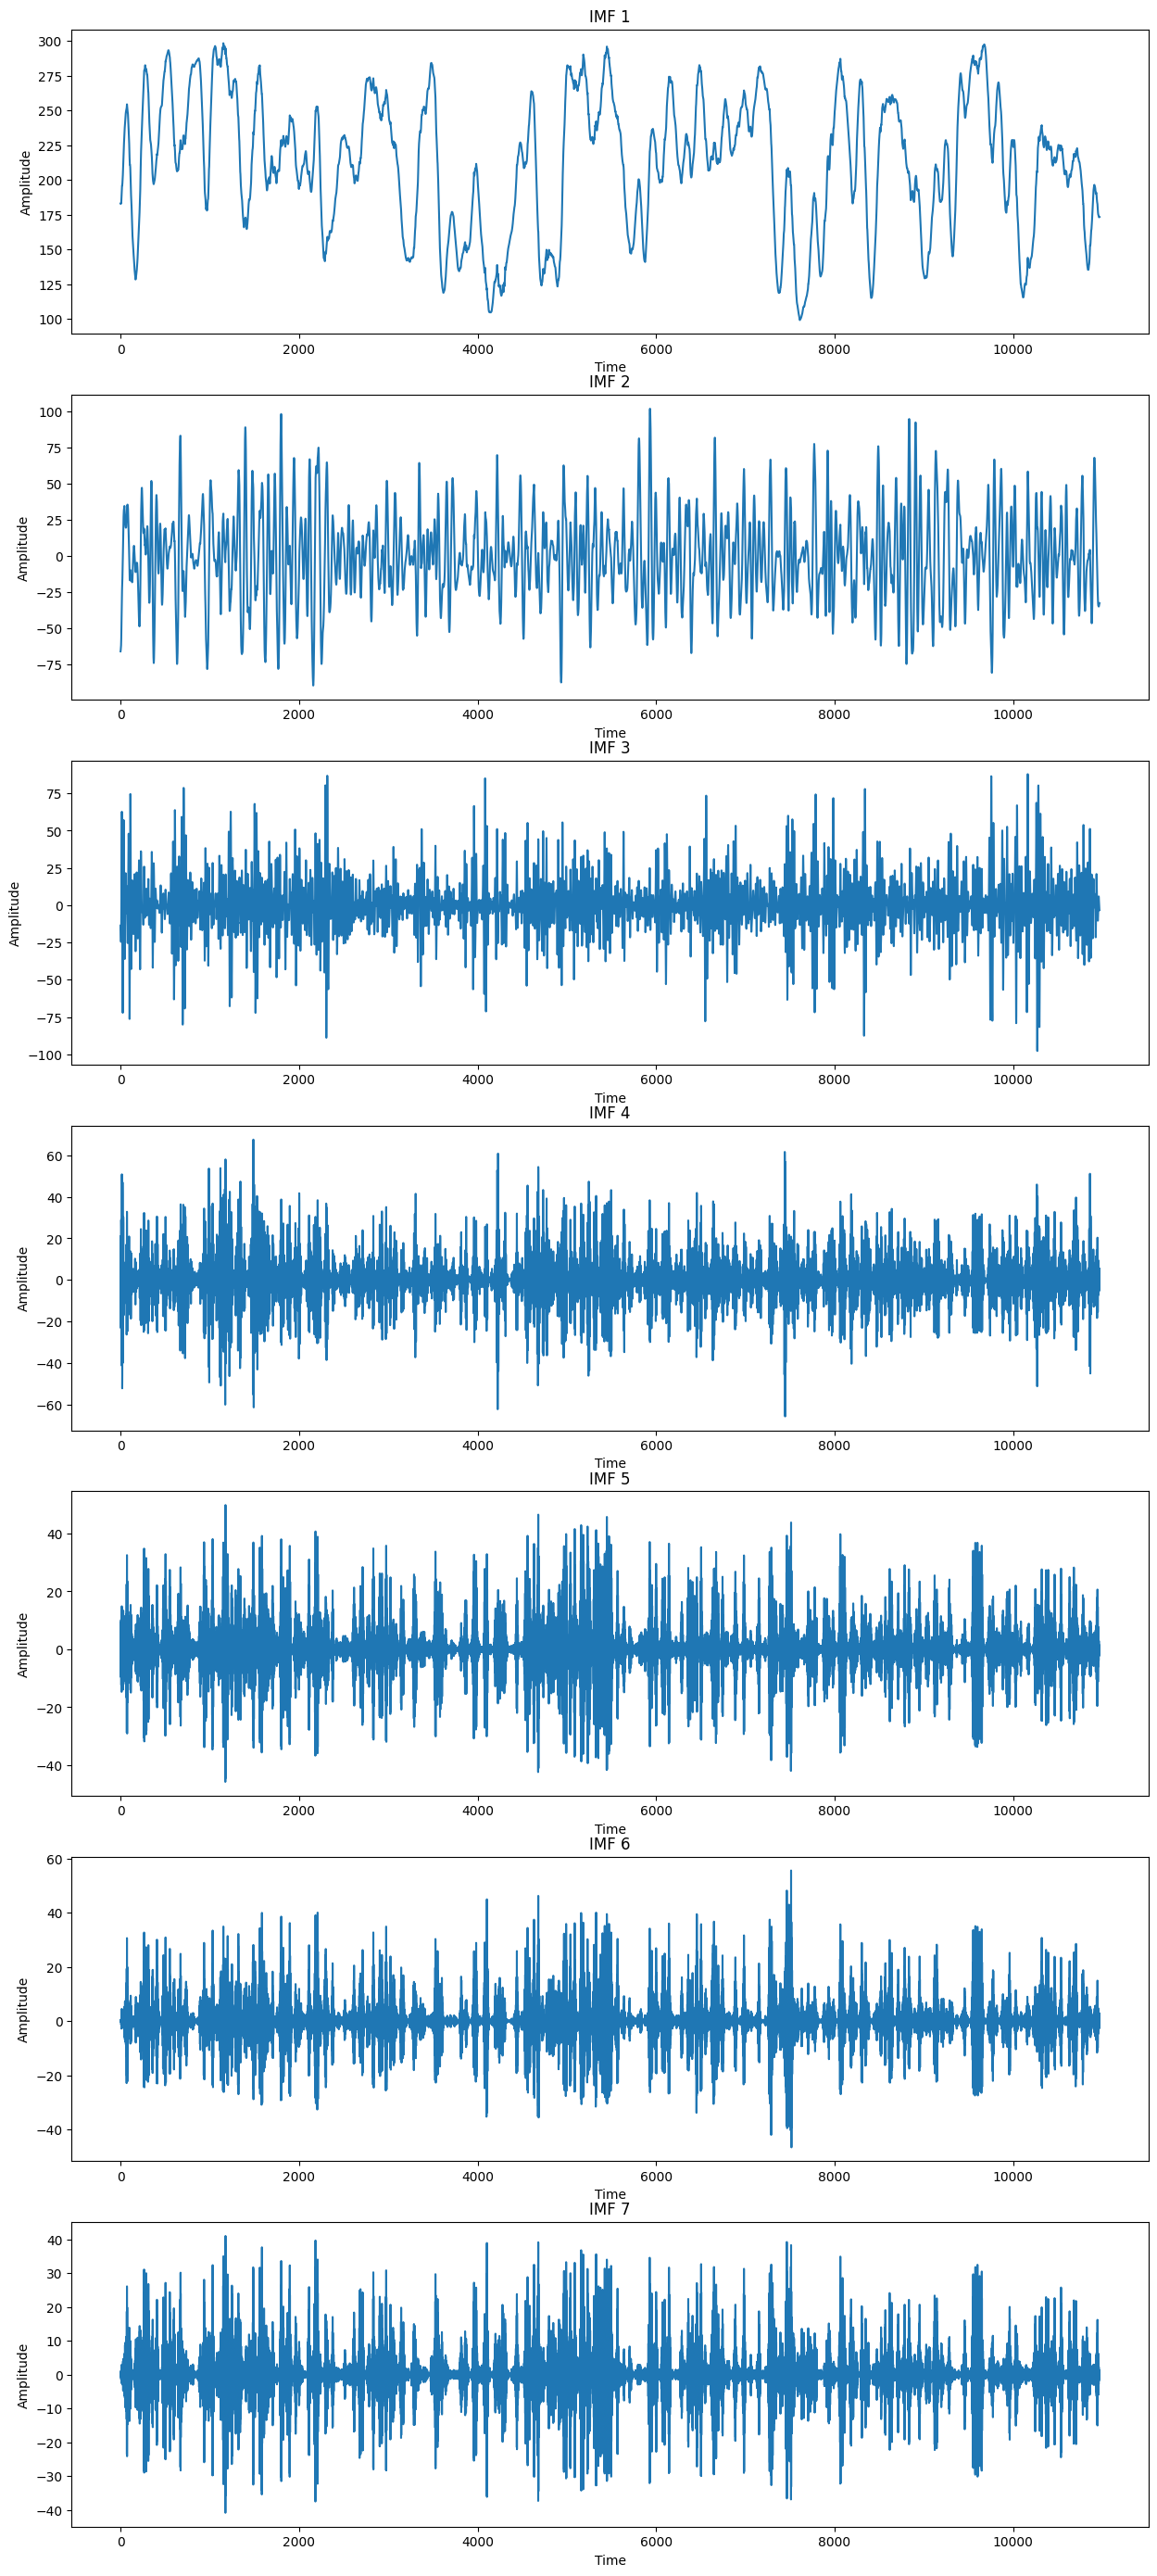

In [37]:
plt.figure(figsize=(15, 5*K))
for k in range(K):
    plt.subplot(K, 1, k+1)
    plt.plot(u[k])
    plt.title(f'IMF {k+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.show()

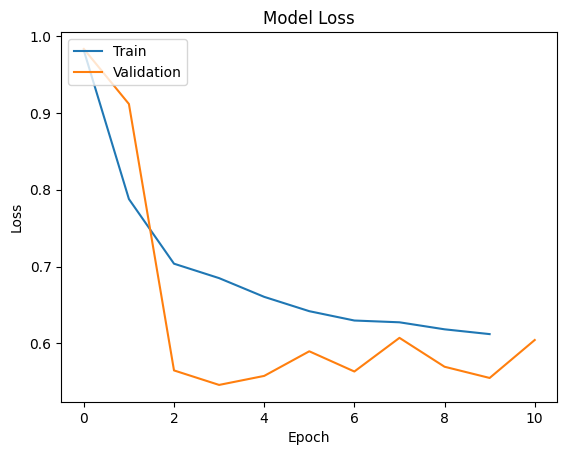

In [45]:
# Plot training & validation loss values
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()